In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 1: Scraping Revenue Data with BeautifulSoup

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# Defining the URL for the Tesla revenue data on Macrotrends
url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
headers = {"User-Agent": "Mozilla/5.0"}

# Fetch the page content
response = requests.get(url, headers=headers)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
else:
    print("Failed to fetch the webpage.")
    exit()

# Locate the revenue table
table = soup.find("table", {"class": "historical_data_table"})
rows = table.find_all("tr")

# Extract data
data = []
for row in rows[1:]:
    cols = row.find_all("td")
    if len(cols) == 2:
        date = cols[0].text.strip()
        revenue = cols[1].text.strip().replace("$", "").replace(",", "")
        if revenue:
            data.append({"Date": date, "Revenue": float(revenue)})

# Create a DataFrame
df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values(by="Date", inplace=True)

# Save to CSV
df.to_csv("tesla_revenue.csv", index=False)
print("Tesla revenue data saved to 'tesla_revenue.csv'!")

# Display Data
print(df.head())


Tesla revenue data saved to 'tesla_revenue.csv'!
         Date  Revenue
14 2009-01-01    112.0
13 2010-01-01    117.0
12 2011-01-01    204.0
11 2012-01-01    413.0
10 2013-01-01   2013.0


Step 2: Analyze Tesla's Revenue

2.1 Year-over-Year Growth

In [24]:
# Adding a Yearly Growth Column
df["YoY Growth (%)"] = df["Revenue"].pct_change() * 100

# Display the DataFrame
print(df)

# Save the analysis
df.to_csv("tesla_revenue_analysis.csv", index=False)


         Date  Revenue  YoY Growth (%)
14 2009-01-01    112.0             NaN
13 2010-01-01    117.0        4.464286
12 2011-01-01    204.0       74.358974
11 2012-01-01    413.0      102.450980
10 2013-01-01   2013.0      387.409201
9  2014-01-01   3198.0       58.867362
8  2015-01-01   4046.0       26.516573
7  2016-01-01   7000.0       73.010381
6  2017-01-01  11759.0       67.985714
5  2018-01-01  21461.0       82.507016
4  2019-01-01  24578.0       14.524020
3  2020-01-01  31536.0       28.309871
2  2021-01-01  53823.0       70.671613
1  2022-01-01  81462.0       51.351653
0  2023-01-01  96773.0       18.795267


2.2 Forecasting Revenue

In [26]:
# Defining the range of future years
last_date = df["Date"].max()
future_years = pd.date_range(start=last_date, periods=6, freq="Y")


<ipython-input-26-172a83a9412e>:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=last_date, periods=6, freq="Y")


In [ ]:
# Ensure the Date column is set as the index
df.set_index("Date", inplace=True)

# Log-transform Revenue to reduce irregular growth
df["Log Revenue"] = np.log1p(df["Revenue"])

# Apply Exponential Smoothing on Log Revenue
model = ExponentialSmoothing(df["Log Revenue"], trend="mul", seasonal=None)
fit = model.fit()
df["Log Forecast"] = fit.fittedvalues

# Define the range of future years
last_date = df.index.max()
future_years = pd.date_range(start=last_date, periods=6, freq="YE")

# Predict Future Revenue and convert back to original scale
future_log_forecast = fit.forecast(len(future_years))
forecast = np.expm1(future_log_forecast)

# Combine Historical and Forecasted Data
future_df = pd.DataFrame({"Date": future_years, "Revenue": forecast})
future_df.set_index("Date", inplace=True)
df_full = pd.concat([df[["Revenue"]], future_df])

# Saving the Forecasted Data
df_full.to_csv("tesla_revenue_forecast_corrected.csv", index=True)
print("Forecasted data saved!")


Forecasted data saved!


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [ ]:
# Saving the files to Google Drive
df.to_csv('/content/drive/My Drive/tesla_revenue.csv', index=False)
df.to_csv('/content/drive/My Drive/tesla_revenue_analysis.csv', index=False)
df_full.to_csv("/content/drive/My Drive/tesla_revenue_forecast_corrected.csv", index=True)
print("File saved to Google Drive!")


Step 3: Visualizations

3.1 Tesla Historical and Forecasted Revenue

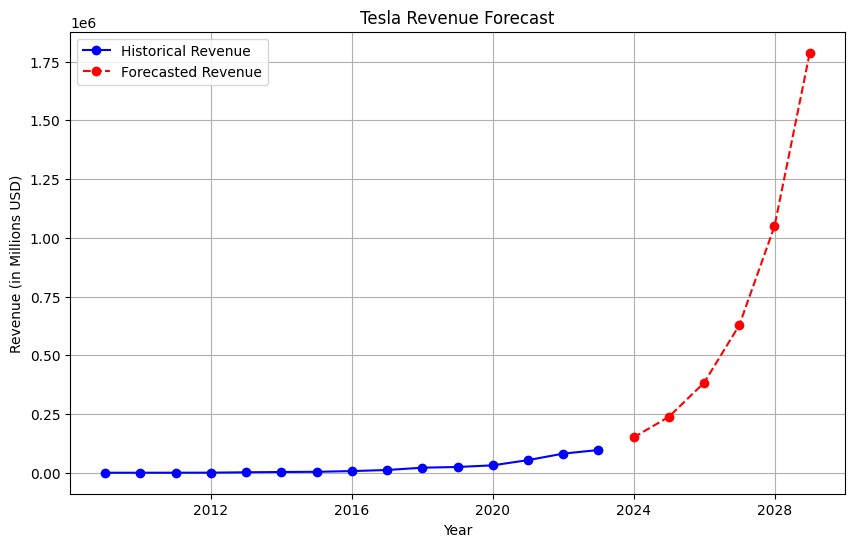

In [ ]:
import matplotlib.pyplot as plt

# Plot Historical and Forecasted Revenue
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Revenue"], marker="o", label="Historical Revenue", color="blue")
plt.plot(future_years, forecast, marker="o", linestyle="--", label="Forecasted Revenue", color="red")
plt.title("Tesla Revenue Forecast")
plt.xlabel("Year")
plt.ylabel("Revenue (in Millions USD)")
plt.legend()
plt.grid()
plt.show()


3.2 Identifying Years with Significant Revenue Growth (>50%)

In [ ]:
significant_growth = df[df["YoY Growth (%)"] > 50]
print("Years with >50% Growth:\n", significant_growth)


Years with >50% Growth:
             Revenue  YoY Growth (%)  Log Revenue  Log Forecast
Date                                                          
2011-01-01    204.0       74.358974     5.323010      4.998000
2012-01-01    413.0      102.450980     6.025866      5.671991
2013-01-01   2013.0      387.409201     7.607878      6.526256
2014-01-01   3198.0       58.867362     8.070594      8.598691
2016-01-01   7000.0       73.010381     8.853808      9.054914
2017-01-01  11759.0       67.985714     9.372459      9.596062
2018-01-01  21461.0       82.507016     9.974039     10.095959
2021-01-01  53823.0       70.671613    10.893475     10.868547
2022-01-01  81462.0       51.351653    11.307904     11.436296


3.3 Visualizing Tesla Revenue with Key Milestones

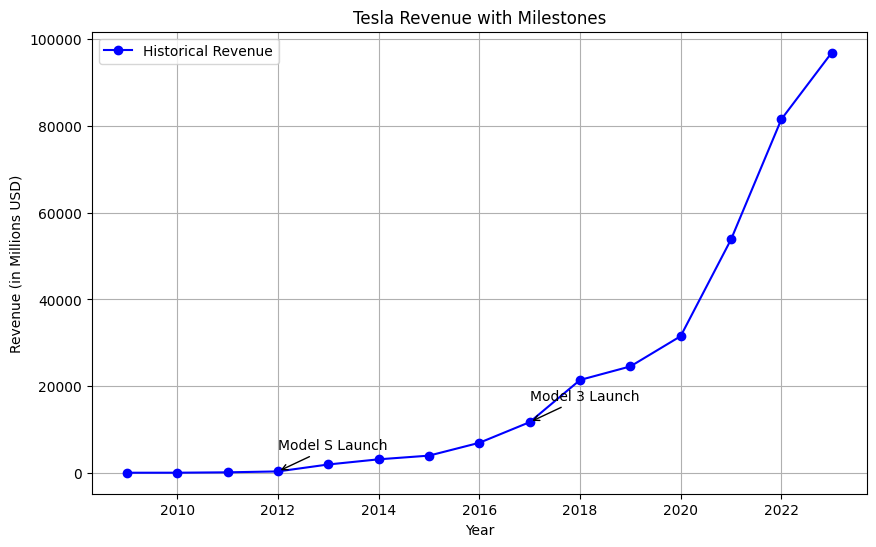

In [ ]:
import pandas as pd

#Milestones' years are converted to datetime
milestones = {
    pd.to_datetime("2012"): "Model S Launch",
    pd.to_datetime("2017"): "Model 3 Launch"
}

# Annotating the milestones on the plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Revenue"], marker="o", label="Historical Revenue", color="blue")

for year, event in milestones.items():
    plt.annotate(
        event,
        xy=(year, df.loc[year, "Revenue"]),
        xytext=(year, df.loc[year, "Revenue"] + 5000),
        arrowprops=dict(facecolor="black", arrowstyle="->"),
        fontsize=10
    )

plt.title("Tesla Revenue with Milestones")
plt.xlabel("Year")
plt.ylabel("Revenue (in Millions USD)")
plt.legend()
plt.grid()
plt.show()


3.4 Categorizing Tesla's Revenue Growth into High, Moderate, and Low Growth

In [ ]:
def categorize_growth(growth):
    if growth > 50:
        return "High Growth"
    elif growth > 20:
        return "Moderate Growth"
    else:
        return "Low Growth"

df["Growth Category"] = df["YoY Growth (%)"].apply(categorize_growth)
print(df[["Revenue", "YoY Growth (%)", "Growth Category"]])


            Revenue  YoY Growth (%)  Growth Category
Date                                                
2009-01-01    112.0             NaN       Low Growth
2010-01-01    117.0        4.464286       Low Growth
2011-01-01    204.0       74.358974      High Growth
2012-01-01    413.0      102.450980      High Growth
2013-01-01   2013.0      387.409201      High Growth
2014-01-01   3198.0       58.867362      High Growth
2015-01-01   4046.0       26.516573  Moderate Growth
2016-01-01   7000.0       73.010381      High Growth
2017-01-01  11759.0       67.985714      High Growth
2018-01-01  21461.0       82.507016      High Growth
2019-01-01  24578.0       14.524020       Low Growth
2020-01-01  31536.0       28.309871  Moderate Growth
2021-01-01  53823.0       70.671613      High Growth
2022-01-01  81462.0       51.351653      High Growth
2023-01-01  96773.0       18.795267       Low Growth


3.5 Counting the Number of Years in Each Growth Category

In [ ]:
print(df["Growth Category"].value_counts())


Growth Category
High Growth        9
Low Growth         4
Moderate Growth    2
Name: count, dtype: int64


3.6 Visualizing the Distribution of Growth Categories Over the Years

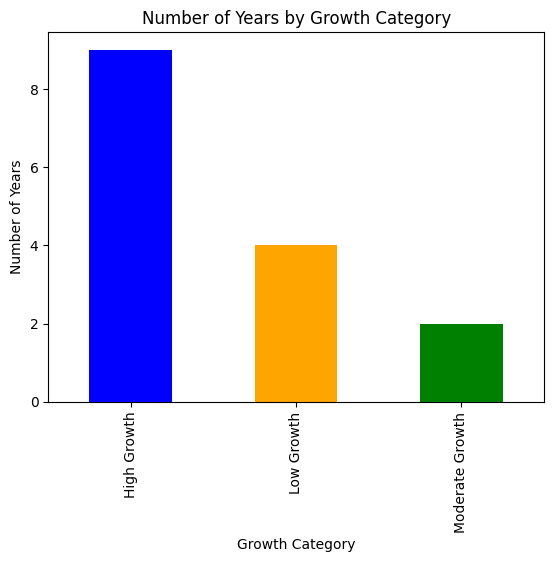

In [ ]:
df["Growth Category"].value_counts().plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Number of Years by Growth Category")
plt.xlabel("Growth Category")
plt.ylabel("Number of Years")
plt.show()
